<a href="https://colab.research.google.com/github/Yassineka99/Analysis_of_Property_Prices_in_Tunisia/blob/main/Analysis_of_Property_Prices_in_Tunisia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [34]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType,StructType, StructField , FloatType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
uploaded = files.upload()

In [37]:
# Get the file name
file_name = list(uploaded.keys())[0]
# Load dataset into a Pandas DataFrame
df = pd.read_csv(file_name)

spark = SparkSession.builder.appName("PropertyPricePrediction").getOrCreate()

In [ ]:
print(df.dtypes)


category           object
room_count        float64
bathroom_count    float64
size              float64
type               object
price             float64
city               object
region             object
log_price         float64
dtype: object


In [ ]:
schema = StructType([
    StructField("category", StringType(), True),
    StructField("room_count", FloatType(), True),
    StructField("bathroom_count", FloatType(), True),
    StructField("size", FloatType(), True),
    StructField("type", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("city", StringType(), True),
    StructField("region", StringType(), True),
    StructField("log_price", FloatType(), True)
])
data = spark.createDataFrame(df, schema=schema)



data.printSchema()
data.show()

In [40]:
indexers = [
    StringIndexer(inputCol="category", outputCol="category_index"),
    StringIndexer(inputCol="type", outputCol="type_index"),
    StringIndexer(inputCol="city", outputCol="city_index"),
    StringIndexer(inputCol="region", outputCol="region_index")
]

for indexer in indexers:
    data = indexer.fit(data).transform(data)


In [41]:
assembler = VectorAssembler(
    inputCols=["city_index","room_count","category_index",
               "region_index","type_index","size","bathroom_count","log_price"],
    outputCol="vector"
)
data = assembler.transform(data)

In [42]:
final_data = data.select("vector", "price")


train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)


lr = LinearRegression(featuresCol="vector", labelCol="price")
lr_model = lr.fit(train_data)


In [44]:
test_results = lr_model.evaluate(test_data)
print(f"R2: {test_results.r2}")

R2: -0.24138569767019935


In [45]:
predictions = lr_model.transform(test_data)

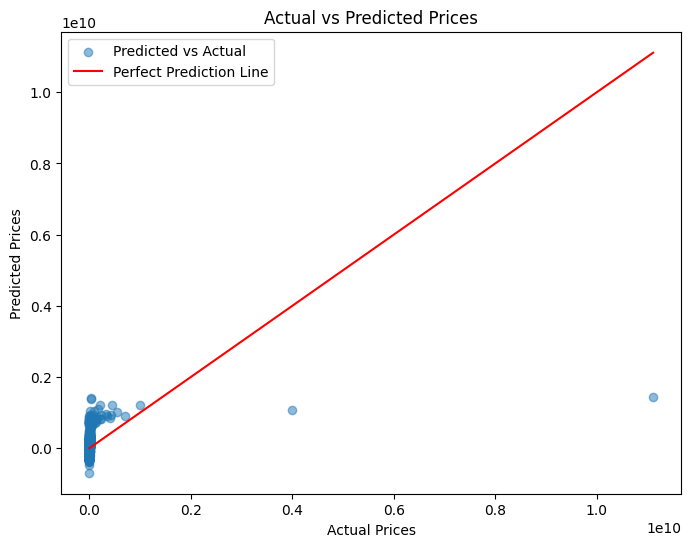

In [48]:
# Visualize predictions vs actual prices
predictions_pd = predictions.select("price", "prediction").toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(predictions_pd["price"], predictions_pd["prediction"]
            , alpha=0.5, label="Predicted vs Actual")
plt.plot(
    [0, max(predictions_pd["price"])],
    [0, max(predictions_pd["price"])],
    color='red',
    linestyle='-',
    label="Perfect Prediction Line"
)
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.show()

In [49]:
from pyspark.sql import functions as F
data = data.withColumn("price_transformed", F.pow(10, data["log_price"]))
assembler = VectorAssembler(
    inputCols=["city_index","room_count","category_index","region_index",
               "type_index","size","bathroom_count","price_transformed"],
    outputCol="vector2"
)
data = assembler.transform(data)

In [50]:
# Select features and label for the model
final_data = data.select("vector2", "price")

# Split the data into training and testing sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Train the Linear Regression model
lr = LinearRegression(featuresCol="vector2", labelCol="price")
lr_model = lr.fit(train_data)

In [51]:
# Evaluate the model
test_results = lr_model.evaluate(test_data)
print(f"R2: {test_results.r2}")
print(f"Root Mean Squared Error (RMSE): {test_results.rootMeanSquaredError}")

R2: 0.9999999999995786
Root Mean Squared Error (RMSE): 155.67750589425503


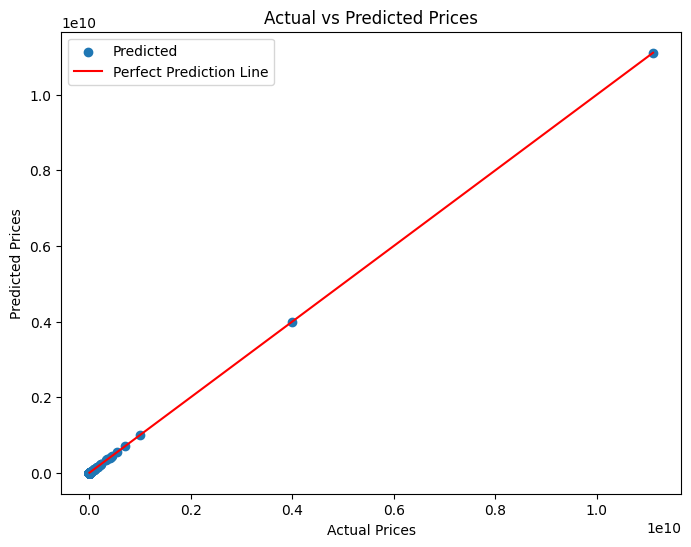

In [53]:
# Visualize predictions vs actual prices
predictions = lr_model.transform(test_data)
predictions_pd = predictions.select("price", "prediction").toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(predictions_pd["price"], predictions_pd["prediction"],
            alpha=1, label="Predicted")
plt.plot(
    [0, max(predictions_pd["price"])],
    [0, max(predictions_pd["price"])],
    color='red',
    linestyle='-',
    label="Perfect Prediction Line"
)
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.show()